## APM 598 - Intro to Deep Learning - Homework 1

<pre>
Team Members:
Sreenivasan Ramesh      -  1217310913  - sreenivasan.ramesh@gmail.com
Tanush Vinay            -  1217104733  - tvinay@asu.edu
Muskan Singhal          -  1217107320  - msingha5@asu.edu
Paarvendhan Puviyarasu  -  1217390616  - ppuviyar@asu.edu
</pre>
</br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch import nn
from torchvision import transforms

############################################## 
		## Exercise 1 (Python) ## 
##############################################

In [ ]:
'''Exercise 1a, 1b, 1c'''
filepath = 'data_HW1_ex1.csv'
data = np.loadtxt(filepath, delimiter=',') 
x, y = data[:,0], data[:,1]
x_train, y_train = data[0:int(len(data)*0.8), 0], data[0:int(len(data)*0.8), 1]
x_test, y_test = data[int(len(data)*0.8):, 0], data[int(len(data)*0.8):, 1]
k = 12


def loss(degree, x, y):
    '''This function computes the loss'''
    return np.sum((np.polyval(np.polyfit(x, y, degree), x) - y)**2)


def ex1a():
    losses = list()
    for degree in range(0, k):
        losses.append(loss(degree, x, y))
    #plot loss against k (k = degree of polynomial)
    plt.figure('Ex. 1a - Loss function vs Poly Degree')
    plt.plot(range(0, k), losses, 'b-')
    plt.xlabel('Degree K')
    plt.ylabel('Loss')
    plt.show()
    
def ex1bc():
    train_error = list()
    test_error = list()

    for degree in range(0, k+1):
        train_error.append(loss(degree, x_train, y_train))
        poly_fit = np.poly1d(np.polyfit(x_train, y_train, degree))
        predict = poly_fit(x_test)
        test_error.append(np.sum((predict-y_test)**2))
    print('Degree   TrainLoss   TestLoss')
    for degree, (train_err, test_err) in enumerate(zip(train_error, test_error)):
        print('%-9i%-13.2f%.2f'%(degree, train_err, test_err))
    k_star = test_error.index(min(test_error))
    print('\nOrder k* = {} since it has the least test error\n'.format(k_star))
    coeffs = np.polyfit(x, y, k_star)
    print('\nCoeffs for k*(2): ', coeffs)

    #display test vs train loss
    fig = plt.figure('Ex. 1b - Test/Train Loss vs Poly Degree', figsize=(12,5))
    ax1 = fig.add_subplot(1, 2, 1)
    train_line, = ax1.plot(range(0, k+1), train_error, c='b')
    test_line, = ax1.plot(range(0, k+1), test_error, c='r')
    ax1.set(xlabel="Degree K", ylabel="Loss")
    ax1.legend([train_line, test_line], ["Train Loss", "Test Loss"])

    #display polyfit
    ax2 = fig.add_subplot(1, 2, 2)
    predict = np.poly1d(np.polyfit(x, y, k_star))
    ax2.plot(x, y, 'bo')
    x_sort = sorted(x)
    p_fit, = ax2.plot(x_sort, predict(x_sort), 'r-')
    ax2.set(xlabel="x", ylabel="y")
    ax2.legend([p_fit], ["K* = {}".format(k_star)])
    plt.show()
     

In [ ]:
print('\n******* Exercise 1 ********\n')
ex1a()
ex1bc()


Guess for k* is 2, since we get the lowest test loss with k=2

</br></br>
############################################## 
    ## Exercise 2 (Python) ## 
##############################################
</br></br>


We are given a loss function. To get the gradient of the loss function, we
- differentiate the loss, with respext to a and b
- we equate the first order differentials to zero
- and we solve the two equations simultaneously to equations for get a and b
- upon pugging in xi and yi values, we will be able to get a* and b*
</br></br>
_note: The derivations and equations are provided in the 2a.pdf / 2a.jpg files_

<img src='2a.jpg'>

In [4]:
'''Exercise 2a, 2b, 2c'''


def loss(a, b, x_train, y_train):
    '''loss function'''
    n = len(x_train)
    loss = 1/n * (np.sum(y_train - (a + b*x_train))**2)
    print(loss)


def calculate_minima(x_train, y_train):
    '''calculating minima for 2a'''
    #Upon differentiating the system of mse loss with respect to 2 variables a and b and
    #equating the first order differential to 0, 
    #we get the following equations for a and b to find their minimum.
    n = len(x_train)
    b_star = (np.sum(x_train*y_train) - (1/n*(np.sum(x_train)*np.sum(y_train)))) / (np.sum((x_train**2)) - (1/n*(np.sum(x_train)**2)))
    a_star = 1/n *(np.sum(y_train) - (b_star * np.sum(x_train)))
    return np.array([a_star,b_star])



def gradient_descent(x_train, y_train, a0, b0, learning_rate, optimal_numerical_ab):
    '''gradient descent'''
    iteration = 1
    n = len(x_train)
    old_ab = np.array([a0, b0])
    a = old_ab[0]
    b = old_ab[1]
    gradient_a = 1/n * (np.sum(-2*(y_train - a - (b * x_train))))
    gradient_b = 1/n * (np.sum(-2*((x_train*y_train) - (a*x_train) - (b*(x_train**2)))))
    grad_ab = np.array([gradient_a,gradient_b])
    new_ab = old_ab - (learning_rate*(grad_ab))
    while((new_ab - old_ab).all() !=0):
        iteration += 1
        old_ab = new_ab
        a = old_ab[0]
        b = old_ab[1]
        gradient_a = 1/n * (np.sum(-2*(y_train - a - (b * x_train))))
        gradient_b = 1/n * (np.sum(-2*((x_train*y_train) - (a*x_train) - (b*(x_train**2)))))
        grad_ab = np.array([gradient_a,gradient_b])
        new_ab = old_ab - (learning_rate*(grad_ab))
    return [iteration, new_ab]



def momentum(x_train, y_train, gamma, a0, b0, learning_rate):
    '''momentum'''
    iteration = 1
    n = len(x_train)
    v_n = np.array([0.0,0.0])
    old_ab = np.array([a0,b0])
    a, b = old_ab[0], old_ab[1]
    gradient_a = 1/n * (np.sum(-2*(y_train - a - (b * x_train))))
    gradient_b = 1/n * (np.sum(-2*((x_train*y_train) - (a*x_train) - (b*(x_train**2)))))
    grad_ab = np.array([gradient_a,gradient_b])
    new_v_n = (gamma * v_n) + (learning_rate*grad_ab)
    new_ab = old_ab - new_v_n
    while((new_ab - old_ab).all() !=0):
        iteration += 1
        old_ab = new_ab
        v_n = new_v_n
        a = old_ab[0]
        b = old_ab[1]
        gradient_a = 1/n * (np.sum(-2*(y_train - a - (b * x_train))))
        gradient_b = 1/n * (np.sum(-2*((x_train*y_train) - (a*x_train) - (b*(x_train**2)))))
        grad_ab = np.array([gradient_a,gradient_b])
        new_v_n = (gamma * v_n) + (learning_rate*grad_ab)
        new_ab = old_ab - new_v_n
    return [iteration, new_ab]



def nesterov_momentum(x_train,y_train,gamma, a0, b0, learning_rate):
    '''nesterov momentum'''
    iteration = 1
    n = len(x_train)
    v_n = np.array([0.0,0.0])
    old_ab = np.array([a0,b0])
    a, b = old_ab[0], old_ab[1]
    gradient_a = 1/n * (np.sum(-2*(y_train - a -(gamma*v_n[0]) - ((b-(gamma*v_n[1])) * x_train))))
    gradient_b = 1/n * (np.sum(-2*((x_train*y_train) - ((a-(gamma*v_n[0]))*x_train) - ((b-(gamma*v_n[1]))*(x_train**2)))))
    grad_ab = np.array([gradient_a,gradient_b])
    new_v_n = (gamma * v_n) + (learning_rate*grad_ab)
    new_ab = old_ab - new_v_n
    while((new_ab - old_ab).all() !=0):
        iteration += 1
        old_ab = new_ab
        v_n = new_v_n
        a = old_ab[0]
        b = old_ab[1]
        gradient_a = 1/n * (np.sum(-2*(y_train - (a -(gamma*v_n[0])) - ((b-(gamma*v_n[1])) * x_train))))
        gradient_b = 1/n * (np.sum(-2*((x_train*y_train) - ((a-(gamma*v_n[0]))*x_train) - ((b-(gamma*v_n[1]))*(x_train**2)))))
        grad_ab = np.array([gradient_a,gradient_b])
        new_v_n = (gamma * v_n) + (learning_rate*grad_ab)
        new_ab = old_ab - new_v_n
    return [iteration, new_ab]



In [5]:
'''Exercise 2a - Deduce the Minimum Numerically'''
#since we're deducing the gradient, we;ve used all points
x_train = data[0:int(len(data)), 0]
y_train = data[0:int(len(data)), 1]

print('\n******* Exercise 2a *************\n')
optimal_ab = calculate_minima(x_train,y_train)
print('Deducing a* b* numerically:\na_star: {}\nb_star:  {}\n'.format(optimal_ab[0], optimal_ab[1]))


******* Exercise 2a *************

Deducing a* b* numerically:
a_star: -0.91372385011034
b_star:  1.356735000649594



In [6]:
print('\n\n******* Exercise 2b, 2c ********')
a0 = 1.8
b0 = 1.4
learning_rate = 0.05
gamma = 0.9

print('Method             Iterations    a_star    b_star')
iterations, new_ab = gradient_descent(x_train, y_train, a0, b0, learning_rate, optimal_ab)
print('Gradient Descent   %-14i%-10.4f%.4f'%(iterations, new_ab[0], new_ab[1]))

iterations, new_ab_momentum = momentum(x_train, y_train, gamma, a0, b0, learning_rate)
print('Using Momentum     %-14i%-10.4f%.4f'%(iterations, new_ab_momentum[0], new_ab_momentum[1]))

iterations, new_ab_nesterov = nesterov_momentum(x_train, y_train,gamma, a0, b0, learning_rate)
print('Nesterov Momentum  %-14i%-10.4f%.4f'%(iterations, new_ab_nesterov[0], new_ab_nesterov[1]))



******* Exercise 2b, 2c ********
Method             Iterations    a_star    b_star
Gradient Descent   4083          -0.9137   1.3567
Using Momentum     624           -0.9137   1.3567
Nesterov Momentum  540           -0.9137   1.3567


</br>
We see that gradient takes the most number of iterations to converge. </br>
Using momentum reducs the number of iterations to reach the same point.</br>
Nesterov Momentum takes the least number of iterations.

</br></br>
############################################## 
    ## Exercise 3 (Python) ## 
##############################################
</br></br>

In [ ]:
'''Exercise 3a, 3b'''
#hyperparameters
n_epochs = 40
learning_rate = 0.0001
batch_size = 4

#downloading the data
batch_size = 4
training_set = datasets.FashionMNIST('data',train=True,download=True,transform=transforms.ToTensor())
testing_set = datasets.FashionMNIST('data',train=False,download=True,transform=transforms.ToTensor())
train_data = DataLoader(training_set,shuffle=True,batch_size=batch_size)
test_data = DataLoader(testing_set,shuffle=False,batch_size=batch_size)


#network
network = nn.Linear(28*28,10)
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)
cal_loss = nn.CrossEntropyLoss()

track_loss=[]
#training
print('******** 3a/b. Training the model ********\nEpoch1...')
for epoch in range(n_epochs):
    running_loss = 0
    minibatch = 0
    for img, lbl in train_data:
        optimizer.zero_grad()
        N, _, h, w = img.size()
        score = network(img.view(N,h*w))
        loss = cal_loss(score,lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().numpy()
        minibatch += 1
    avg_loss = running_loss/minibatch
    track_loss.append(avg_loss)
    print("Epoch: {}   Average Loss:{}".format(epoch+1, avg_loss))
    
print('\n******* 3b. Loss vs Epoch ********')   
#Plot training statistics
plt.plot([i for i in range(n_epochs) ],track_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
weights = network.state_dict()['weight']
plt.clf()

******** 3a/b. Training the model ********
Epoch1...
Epoch: 1   Average Loss:0.7104062395040567
Epoch: 2   Average Loss:0.5153351884400161
Epoch: 3   Average Loss:0.47707004281822785
Epoch: 4   Average Loss:0.45686964267330865
Epoch: 5   Average Loss:0.4436050772742892
Epoch: 6   Average Loss:0.4341782736311279
Epoch: 7   Average Loss:0.4267614948740763
Epoch: 8   Average Loss:0.4213390374780555
Epoch: 9   Average Loss:0.41676655061615164
Epoch: 10   Average Loss:0.4122927877229192
Epoch: 11   Average Loss:0.40909827903906504
Epoch: 12   Average Loss:0.4063789827695378
Epoch: 13   Average Loss:0.40379856264955405
Epoch: 14   Average Loss:0.40119862130430606
Epoch: 15   Average Loss:0.3990019700946592
Epoch: 16   Average Loss:0.39675837728932384
Epoch: 17   Average Loss:0.3953650175092412
Epoch: 18   Average Loss:0.3943526683848089
Epoch: 19   Average Loss:0.39206521415633516


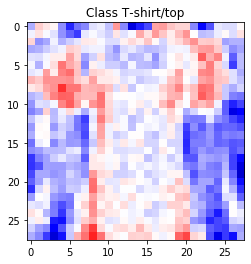

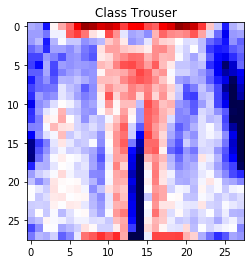

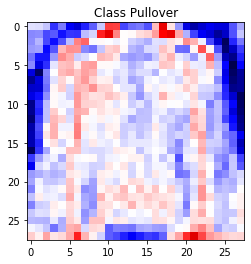

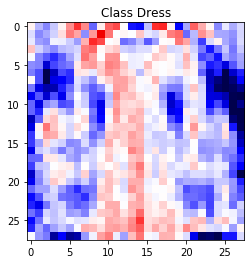

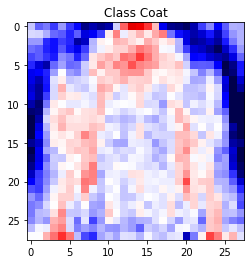

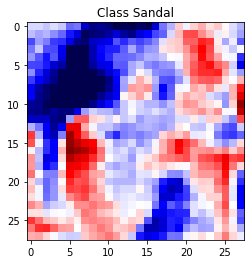

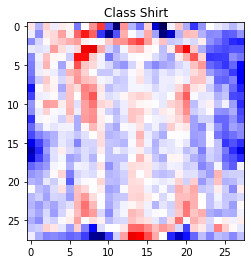

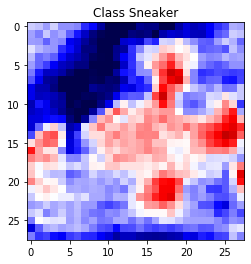

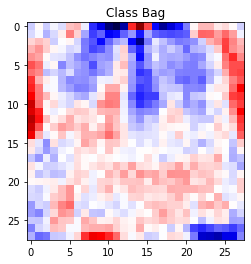

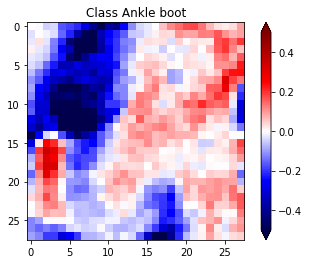

In [69]:
'''Exercise 3c - drawing the template classes'''

classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
for i in range(10):
    plt.figure()
    plt.imshow(weights[i].view(28,28),vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.title('Class {}'.format(classes[i]))
  
plt.colorbar(extend='both')